In [16]:
# Standard python libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal

In [17]:
# Import from a higher directory
import sys
sys.path.append("..")

In [18]:
# Class to build a neural network in keras
from NeuralNets4OM import Neural_Network
# Class to export neural network to OpenModelica
from NeuralNets4OM import Neural_OM_Model as nom

Methode to load Data Load Data of the a magnetic levitation system. The input describe the voltage applied to the electromagnet, the output describes the position of the permanent magnet

In [19]:
def load_data():
    inputs=np.loadtxt('Data/inputs.csv',delimiter=',')
    outputs=np.loadtxt('Data/outputs.csv',delimiter=',')
    u_inter=inputs[:3200]
    y_inter=outputs[:3200]
    u_extra=inputs[3200:]
    y_extra=outputs[3200:]
    return u_inter, y_inter, u_extra, y_extra

Load the input and the output data

In [20]:
u,y,u_pre,y_pre=load_data()

Plot the given data that is used for the training

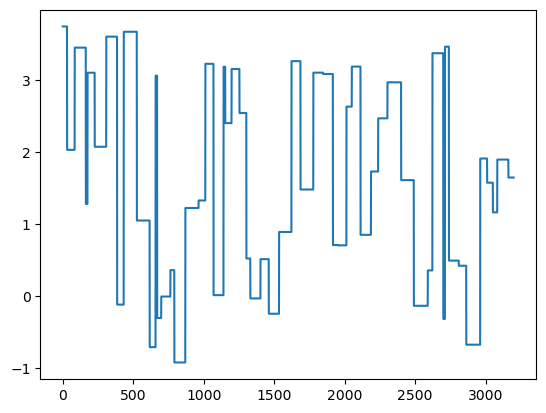

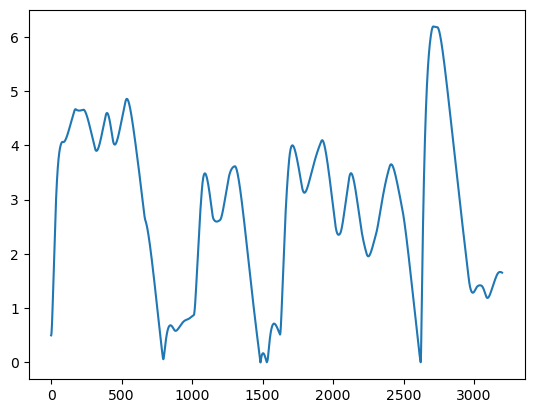

In [21]:
plt.plot(u)
plt.show()
plt.plot(y)
plt.show()

Plot the data that will be used for later prediction

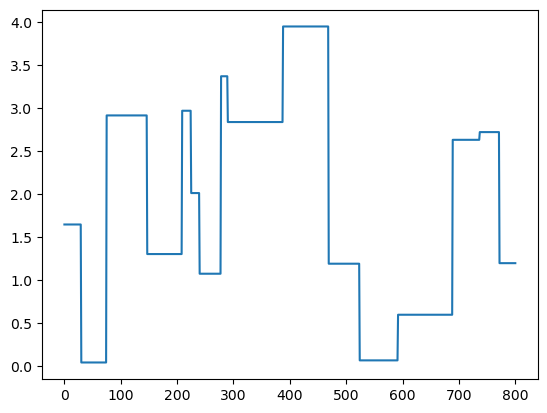

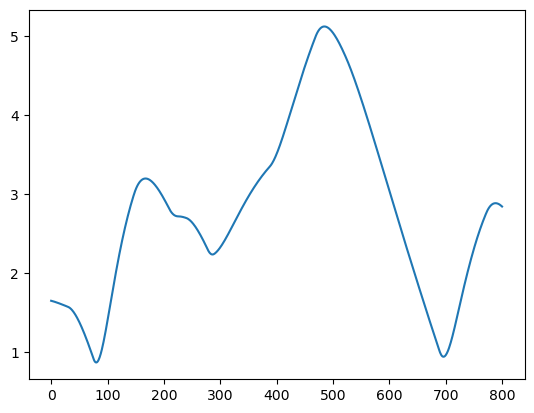

In [22]:
plt.plot(u_pre)
plt.show()
plt.plot(y_pre)
plt.show()

# Preanalysis of the Dataset

In [23]:
df_u=pd.DataFrame(u)
df_y=pd.DataFrame(y)

                 0
count  3200.000000
mean      1.575976
std       1.385578
min      -0.923630
25%       0.422043
50%       1.577559
75%       3.089872
max       3.750646


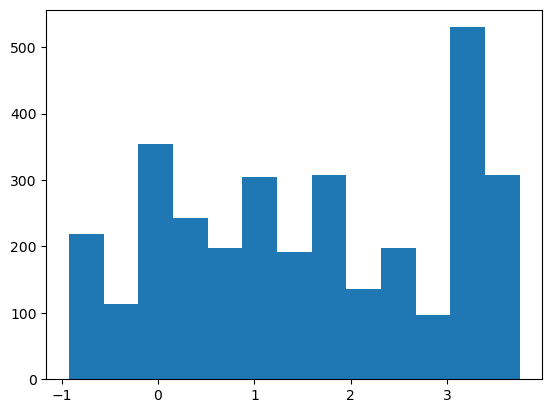

In [24]:
print(df_u.describe())
plt.hist(u, bins='auto')
plt.show()

                 0
count  3200.000000
mean      2.802104
std       1.479286
min       0.000276
25%       1.500494
50%       2.980817
75%       3.939310
max       6.189851


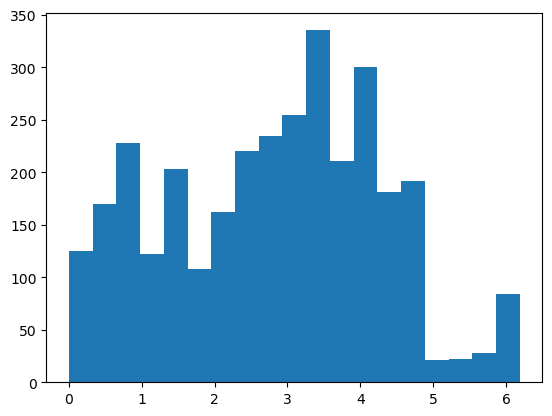

In [25]:
print(df_y.describe())
plt.hist(y, bins='auto')
plt.show()

There is no really normal distribution to discover, so scaling should be used. Before this is done check with 3-sigma-rule if outliers are in the inputs

In [26]:
#1.1 Outliear detection mean and median for u
pd.DataFrame([df_u.mean(),df_u.median()], ["mean","median"])

,0
mean,1.575976
median,1.577559


Result: Mean and median are very close to each other, which means that the dataset has no outliers

In [27]:
outlier=np.abs((df_u._get_numeric_data()-df_u.mean())/df_u.std())>2
df_u._get_numeric_data()[outlier].dropna(how="any")

,0


The result is approved by the 2-sigma rule

In [28]:
#1.2 Outliear detection mean and median for y
pd.DataFrame([df_y.mean(),df_y.median()], ["mean","median"])

,0
mean,2.802104
median,2.980817


Result: Same result as for the inputs, there are no indicators for outliers

In [29]:
outlier=np.abs((df_y._get_numeric_data()-df_y.mean())/df_y.std())>3
df_y._get_numeric_data()[outlier].dropna(how="any")

,0


With 3-sigma rule there are also no outlier, this relaxtion could be used because scaling the outputs is not so important!

# Identification of the approximated time delay

As a rule one can say that more delays are helpfull to model more complex systems!

In [30]:
def corrfunc(inpt,outpt):
    #Scale input and output respectively to [0,1] for better comparability
    min_in=inpt.min(axis=0)
    max_in=inpt.max(axis=0)
    min_out=outpt.min(axis=0)
    max_out=outpt.max(axis=0)
    i=(inpt-min_in)/(max_in-min_in)
    o=(outpt-min_out)/(max_out-min_in)
    
    plt.plot(i)
    plt.plot(o)
    plt.show()
    # calculate crosscorrelation
    corr=signal.correlate(i,o,mode='full')
    # Normalize the result so that the maximum has the value 1
    corr /= np.max(corr)
    # Function returns an array containing the indices of the forward resp. backward shift,
    # where the index '0' is the one where the two signals are identical
    lags=signal.correlation_lags(len(i), len(o))
    # Find the index maximum value of the cross-correlation and return the associated index shift
    return lags[np.argmax(corr)]

Set the delay for the inputs and the outputs of the system based on the cross correlation

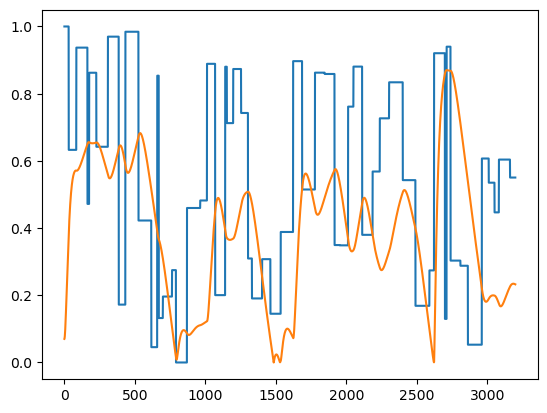

Index shift: -55


In [31]:
tau=corrfunc(u,y)
if tau < 0:
    print("Index shift: {}".format(tau))
    tau*=-1
else:
    print("No identification of delay with crosscorrelation possible!")

This means that there is an approximated time delay of about 0.55 seconds! To obtain a suitable correlation between input and output, a delay in this order of magnitude should be used!

# Generate the feature vector with an choosen time delay shift

Define a function that delays the features and targets by a given delay

In [32]:
def delay(ipts,opts,delay):
    # Initialize list for the new features
    feature_list=[ipts[delay:]]
     # Generate delayed inputs and add them to features
    for i in range(1,delay+1):
        feature_list.append(ipts[delay-i:-i])
    # Generate delayed outputs and add them to features
    for j in range(1,delay+1):
        feature_list.append(opts[delay-j:-j])
    return np.stack(feature_list,axis=1)

Based on the delay defined above generate the features and targets to train the neural network

In [36]:
features=delay(u,y,tau)
targets=y[tau:]

Save the Testdata to use it in the Modelica model

In [19]:
#np.savetxt('test_u.txt', np.vstack([np.arange(0.0,len(u_pre[tau:]))/100,u_pre[tau:]]).T, delimiter=',', newline=';', fmt='%8.8f')
#np.savetxt('test_y.txt', np.vstack([np.arange(0.0,len(y_pre[tau:]))/100,y_pre[tau:]]).T, delimiter=',', newline=';', fmt='%8.8f')

# Train the neural network as a normal feedforward network

In [20]:
nn = Neural_Network.Neural_Network(features,targets)

In [21]:
features_train, features_test, features_max, features_min = nn.scaling(nn.X_train, nn.X_test)

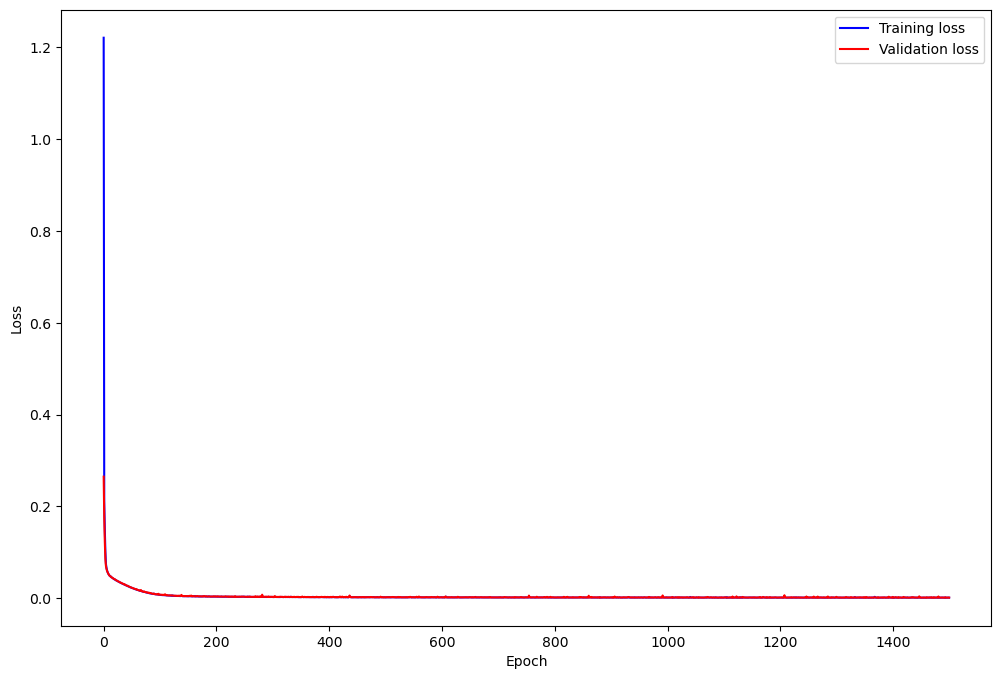

In [22]:
nn.train(features_train, nn.Y_train)

In [23]:
nn.nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                2688      
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25        
Total params: 3,313
Trainable params: 3,313
Non-trainable params: 0
_________________________________________________________________


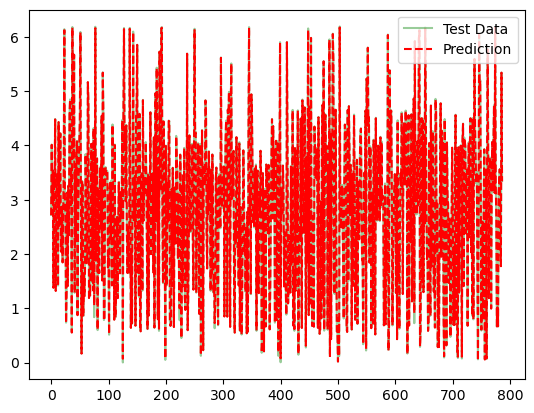

0.008207565683397705


In [24]:
nn.predict_on_test_data(features_test, nn.Y_test,verbose=True)

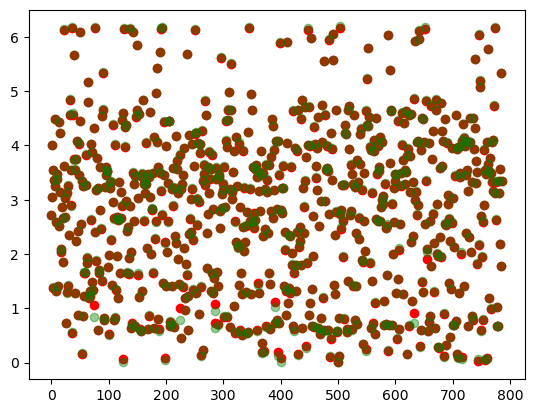

In [25]:
plt.plot(nn.Y_pred,'ro')
plt.plot(nn.Y_test,'go',alpha=0.4)
plt.show()

# Check if the network makes good predictions

Build the delayed input vector

In [26]:
# Initialize list for the delayed inputs
inputs_list=[u_pre[tau:]]
# Generate delayed inputs and add them to features
for i in range(1,tau+1):
    inputs_list.append(u_pre[tau-i:-i])
delayed_inputs=np.stack(inputs_list,axis=1)

For the first tau-steps the original outputs are needed 

In [27]:
delayed_outputs=np.flip(y_pre[:tau])

Save the first delayed input vector for the modelica model

In [28]:
np.savetxt('init_pred.txt', np.concatenate([delayed_inputs[0],delayed_outputs]), delimiter=',', newline=',', fmt='%8.8f')

Loop over the input vector, and replace the outputs with the prediction made by the network

In [29]:
output_net=[]
for i in range(0,delayed_inputs.shape[0]):
    net_in=(np.concatenate([delayed_inputs[i],delayed_outputs])-features_min)/(features_max-features_min)
    net_out=nn.nn.predict(np.array([net_in,])).reshape(-1)
    output_net.append(net_out[0])
    delayed_outputs=np.concatenate([net_out,delayed_outputs[:-1]])

Plot the result 

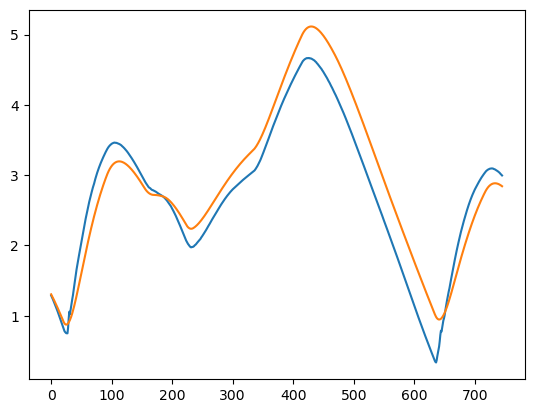

In [30]:
plt.plot(output_net)
plt.plot(y_pre[tau:])
plt.show()

Generate a Modelica model of the neural network

In [31]:
NeuralOM = nom.Neural_OM_Model(nn.nn, ("false", None, None, None), ("true", features_max, features_min), ("false", None, None), ("false", None, None), ("false", None, None), "NARX")
NeuralOM.build_OM_Model()

# Make a PCA to create a new feature vector

First off all it is a good approach to standardize the delayed feature vector

In [20]:
mu=np.mean(features,axis=0)
sigma=np.std(features,axis=0)
X=(features-mu)/sigma

Calculate the covariance matrix

In [21]:
Sigma=np.cov(X.T)

Calculate the eigenvalues and eigenvectors of the covariance matrix

In [22]:
(lamb,w)=np.linalg.eig(Sigma)

Sort the eigenvalues in descending order

In [23]:
eigVar=np.sort(lamb)[::-1]

Brief graphical analysis of how the data are pronounced according to the main axes

In [24]:
sumEig = np.sum(lamb)
eigVar = eigVar/sumEig
cumVar= np.cumsum(eigVar)

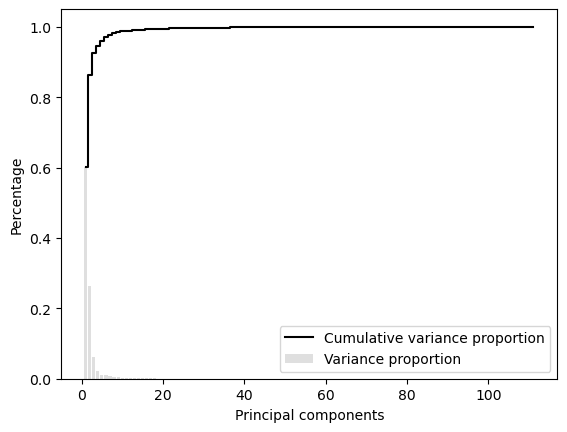

In [25]:
plt.figure()
plt.bar(range(1,len(eigVar)+1),eigVar, alpha=0.25, align='center',
label='Variance proportion', color='gray')
plt.step(range(1,len(eigVar)+1),cumVar, where='mid',
label='Cumulative variance proportion', c='k')
plt.xlabel('Principal components'); plt.ylabel('Percentage')
plt.legend()
plt.show()

Get the the size of the dimension where the cumulative variance propotion is higher then 99.5 percent.

In [26]:
pca_idx=np.argmax(cumVar>=0.995)
print(pca_idx)

21


Sort the eigenvectors according to their eigenvalues arranged in descending order

In [27]:
eigenVarIdx=np.argsort(lamb)[::-1]
W=w[:,eigenVarIdx[0:pca_idx]]

In [28]:
feature_new=(W.T@X.T).T

21

# Train the neural network with the new feature vector

In [29]:
nn = Neural_Network.Neural_Network(feature_new,targets)

In [30]:
features_train, features_test, features_max, features_min = nn.scaling(nn.X_train, nn.X_test)

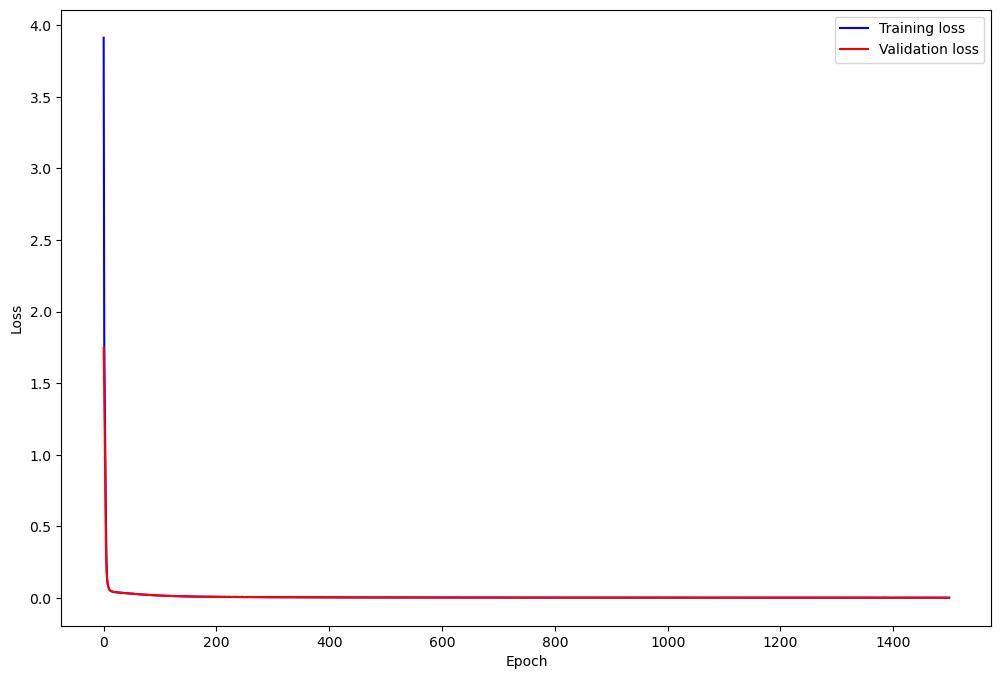

In [31]:
nn.train(features_train, nn.Y_train)

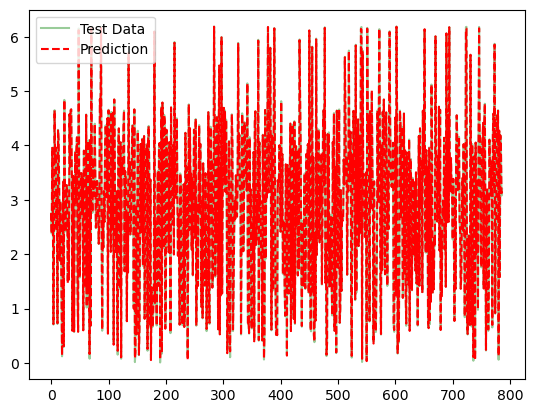

0.009588655199576123


In [32]:
nn.predict_on_test_data(features_test, nn.Y_test,verbose=True)

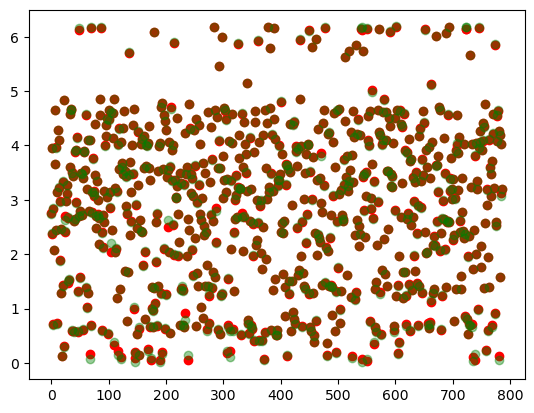

In [33]:
plt.plot(nn.Y_pred,'ro')
plt.plot(nn.Y_test,'go',alpha=0.4)
plt.show()

# Check the prediction of the neural network with with previous PCA

In [34]:
# Initialize list for the delayed inputs
inputs_list=[u_pre[tau:]]
# Generate delayed inputs and add them to features
for i in range(1,tau+1):
    inputs_list.append(u_pre[tau-i:-i])
delayed_inputs=np.stack(inputs_list,axis=1)

In [35]:
delayed_outputs=np.flip(y_pre[:tau])

In [36]:
output_net=[]
for i in range(0,delayed_inputs.shape[0]):
    f=(np.concatenate([delayed_inputs[i],delayed_outputs])-mu)/sigma
    net_in=((W.T@f.T).T-features_min)/(features_max-features_min)   
    net_out=nn.nn.predict(np.array([net_in,])).reshape(-1)
    output_net.append(net_out[0])
    delayed_outputs=np.concatenate([net_out,delayed_outputs[:-1]])

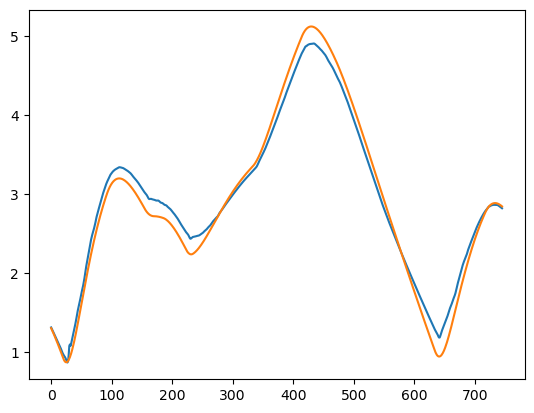

In [37]:
plt.plot(output_net)
plt.plot(y_pre[tau:])
plt.show()

Generate a Modelica model of the neural network with the feature reduction based on the previous PCA

In [38]:
NeuralOM = nom.Neural_OM_Model(nn.nn, ("true", W.T, mu, sigma), ("true", features_max, features_min), ("false", None, None), ("false", None, None), ("false", None, None), "NARX_PCA")
NeuralOM.build_OM_Model()